# Flow Matching on $\mathrm{SE}(2) \times \mathbb{R}^2$
In this notebook, we perform flow matching on the direct product of the roto-translation group $\mathrm{SE}(2)$ and the translation group $\mathbb{R}^2$, corresponding to Figure 3 in ["Flow Matching on Lie Groups"]().

In [14]:
import torch
import numpy as np
# from ... import lieflow
from lieflow.groups import (
    Tn,
    Rn,
    TnbyRn,
    _mod_offset
)
from lieflow.models import (
    get_model_FM,
    LogarithmicDistance
)
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 10.0,
    "text.latex.preamble": r"\usepackage{lmodern} \usepackage{amssymb} \usepackage{amsmath}"
})
from tqdm import tqdm

In [15]:
t1 = Tn(1)
r2 = Rn(2)
t1byr2 = TnbyRn(t1, r2)

In [16]:
generate_videos = True

# Distributions

In [17]:
# def generate_normals_SE2(N):
#     translations = np.random.randn(N, 2)
#     rotations = 2 * np.pi * np.random.rand(N)
#     g = np.hstack((translations, rotations[..., None]))
#     return torch.Tensor(g)

def generate_normals_T1(N):
    translations = np.random.randn(N, 1)
    g = translations
    # rotations = 2 * np.pi * np.random.rand(N)
    # g = np.hstack((translations, rotations[..., None]))
    return torch.Tensor(g)

def generate_uniforms_on_interval_T1(N, centre=0., w=1., ε=0.05):
    xs = 2 * w * (np.random.rand(N) - 0.5)
    gs = torch.Tensor(xs[..., None])
    gse = gs + ε * torch.randn(gs.shape)
    return gse # or just gs?

# generate_uniforms_on_interval_T1(300)

# def generate_uniforms_on_circle_SE2(N, centre=np.array((0., 0.)), ε=0.05):
#     normals = torch.Tensor(np.random.randn(N, 2))
#     lengths = (normals**2).sum(dim=-1).sqrt()
#     non_zero = lengths > 0.
#     circle_samples = normals[non_zero] / lengths[non_zero, None]
#     angles = _mod_offset(torch.arctan2(circle_samples[..., 1], circle_samples[..., 0]), 2 * np.pi, 0.)
#     gs = torch.hstack((circle_samples + torch.Tensor(centre), angles[..., None]))
#     return gs + ε * torch.randn(gs.shape)

# def generate_line_SE2(N, d=0., w=1., horizontal=True, ε=0.05):
#     if horizontal:
#         xs = 2 * w * (np.random.rand(N) - 0.5)
#         ys = np.ones(N) * d
#         angles = np.ones(N) * np.pi / 2.
#     else:
#         xs = np.ones(N) * d
#         ys = 2 * w * (np.random.rand(N) - 0.5)
#         angles = np.zeros(N)
#     gs = torch.Tensor(np.hstack((xs[..., None], ys[..., None], angles[..., None])))
#     return gs + ε * torch.randn(gs.shape)

def generate_normals_R2(N):
    return torch.Tensor(np.random.randn(N, 2))

def generate_uniforms_on_circle_R2(N, ε=0.04):
    normals = generate_normals_R2(N)
    lengths = (normals**2).sum(dim=-1).sqrt()
    non_zero = lengths > 0.
    circle_samples = normals[non_zero] / lengths[non_zero, None]
    return circle_samples + ε * torch.randn(circle_samples.shape)

In [18]:
# tests = ("line_by_normal_to_circle_by_circle",)
tests = ("normal_by_normal_to_interval_by_circle",)

In [23]:
def data_generator(test, ε=0.04):
    match test:
        # case "line_by_normal_to_line_by_circle":
        #     generate_g_0 = lambda n: torch.hstack((
        #         generate_line_SE2(n, d=-2.5, w=1.5, horizontal=False, ε=ε),
        #         generate_normals_R2(n)
        #     ))
        #     generate_g_1 = lambda n: torch.hstack((
        #         generate_line_SE2(n, d=2.5, w=1.5, horizontal=False, ε=ε),
        #         generate_uniforms_on_circle_R2(n, ε=ε)
        #     ))
        case "normal_by_normal_to_interval_by_circle":
            generate_g_0 = lambda n: torch.hstack((
                generate_normals_T1(n),
                generate_normals_R2(n)
            ))
            generate_g_1 = lambda n: torch.hstack((
                generate_uniforms_on_interval_T1(n, centre=torch.pi, w=torch.pi / 6, ε=ε),
                generate_uniforms_on_circle_R2(n, ε=ε)
            ))
        case _:
            raise ValueError(f"Unknown test case: {test}")
    return generate_g_0, generate_g_1

# Models

## Training

In [20]:
EPSILON = 0.03
N = 2**14
BATCH_SIZE = 2**10
EPOCHS = len(tests) * [100]
WEIGHT_DECAY = 0.
LEARNING_RATE = 1e-2
H = 64 # Width
L = 3 # Number of layers is L + 2
device = "cpu"

In [25]:
def train_model(g_0s, g_1s, epochs, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY):
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(g_0s, g_1s), batch_size=batch_size, shuffle=True
    )

    model_FM = get_model_FM(t1byr2, H=H, L=L).to(device)
    print("Number of parameters: ", model_FM.parameter_count)
    optimizer_FM = torch.optim.Adam(model_FM.parameters(), learning_rate, weight_decay=weight_decay)
    loss = LogarithmicDistance(torch.Tensor([1., 1., 1., ]))

    losses_FM = np.zeros(epochs)
    for i in tqdm(range(epochs)):
        losses_FM[i] = model_FM.train_network(device, train_loader, optimizer_FM, loss)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(losses_FM)
    ax.set_title("Batch Loss Flow Matching")
    ax.set_xscale("log")
    ax.set_yscale("log")

    return model_FM

normal_by_normal_to_interval_by_circle
Ready to plot
Number of parameters:  4675


100%|██████████| 100/100 [00:13<00:00,  7.65it/s]


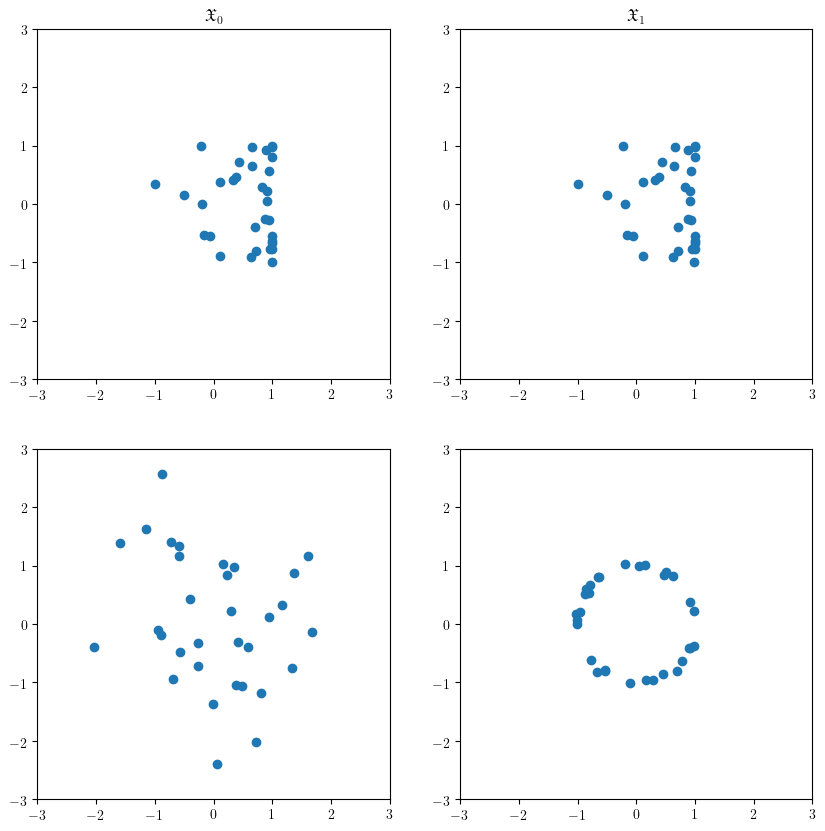

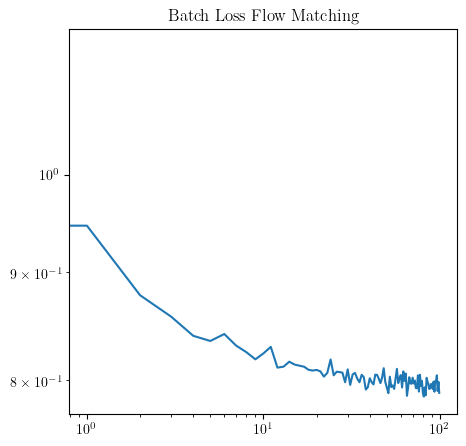

In [ ]:
models_FM = {}
for i, test in enumerate(tests):
    print(test)
    generate_g_0, generate_g_1 = data_generator(test, ε=EPSILON)

    g_0s = generate_g_0(N)
    g_1s = generate_g_1(N)

    print("Ready to plot")
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    # ax[0, 0].quiver(g_0s[:32, 0], g_0s[:32, 1], torch.cos(g_0s[:32, 2]), torch.sin(g_0s[:32, 2]), color="tab:blue")
    ax[0, 0].scatter(torch.cos(g_0s[:32, 0]), torch.sin(g_0s[:32, 1]))
    ax[0, 0].set_xlim(-3, 3)
    ax[0, 0].set_ylim(-3, 3)
    ax[0, 0].set_title(r"$\mathfrak{X}_0$")
    ax[1, 0].scatter(g_0s[:32, -2], g_0s[:32, -1])
    ax[1, 0].set_xlim(-3, 3)
    ax[1, 0].set_ylim(-3, 3)
    ax[0, 1].scatter(torch.cos(g_1s[:32, 0]), torch.sin(g_1s[:32, 1]))  
    ax[0, 1].set_xlim(-3, 3)
    ax[0, 1].set_ylim(-3, 3)
    ax[0, 1].set_title(r"$\mathfrak{X}_1$")
    ax[1, 1].scatter(g_1s[:32, -2], g_1s[:32, -1])
    ax[1, 1].set_xlim(-3, 3)
    ax[1, 1].set_ylim(-3, 3)

    models_FM[test] = train_model(g_0s, g_1s, epochs=EPOCHS[i], batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE,
                                  weight_decay=WEIGHT_DECAY)

## Testing

In [34]:
def create_animations(tests, models_FM, N=2**5):
    N_models = len(tests)

    g_0s_test = {}
    g_ts_test = {}
    for test in tests:
        generate_g_0, _ = data_generator(test, ε=EPSILON)
        g_0s_test[test] = generate_g_0(N).to(device)
        g_ts_test[test] = g_0s_test[test].detach().clone()
        
        models_FM[test].eval()

    t = 0
    N_steps = 120
    Δt = 1. / N_steps
    metadata = {'title': 'Flow Matching T^1 x R^2', 'artist': 'Matplotlib'}
    writer = FFMpegWriter(fps=30, metadata=metadata)

    fig, ax = plt.subplots(2, N_models, figsize=(5 * N_models, 2 * 5))

    with writer.saving(fig, f"output/flow_matching_T1_by_R2.mp4", dpi=150):
        for i, test in enumerate(tests):
            g_ts_test_plot = g_ts_test[test].to("cpu")
            ax[0].quiver(
                g_0s_test[test][:, 0], g_0s_test[test][:, 1],
                torch.cos(g_0s_test[test][:, 2]), torch.sin(g_0s_test[test][:, 2]),
                color="tab:blue"
            )
            ax[0].set_xlim(-3, 3)
            ax[0].set_ylim(-3, 3)
            ax[0].set_title(r"$\mathfrak{X}_0$")
            ax[1].scatter(
                g_ts_test_plot[:, -2], g_ts_test_plot[:, -1]
            )
            ax[1].set_xlim(-3, 3)
            ax[1].set_ylim(-3, 3)
        writer.grab_frame()
        for frame in tqdm(range(N_steps)):
            t = frame * Δt
            for i, test in enumerate(tests):
                with torch.no_grad():
                    g_ts_test[test] = models_FM[test].step(g_ts_test[test], torch.Tensor([t]), Δt)
                g_ts_test_plot = g_ts_test[test].to("cpu")
                ax[0].clear()
                ax[1].clear()
                ax[0].quiver(
                    g_ts_test_plot[:, 0], g_ts_test_plot[:, 1],
                    torch.cos(g_ts_test_plot[:, 2]), torch.sin(g_ts_test_plot[:, 2]),
                    color="tab:blue"
                )
                ax[0].set_xlim(-3, 3)
                ax[0].set_ylim(-3, 3)
                ax[0].set_title(fr"$\mathfrak{{X}}_{{{t:.2f}}}$")
                ax[1].scatter(
                    g_ts_test_plot[:, -2], g_ts_test_plot[:, -1]
                )
                ax[1].set_xlim(-3, 3)
                ax[1].set_ylim(-3, 3)
            writer.grab_frame()
        writer.grab_frame()

In [36]:
# if generate_videos:
#     create_animations(tests, models_FM, N=2**5)

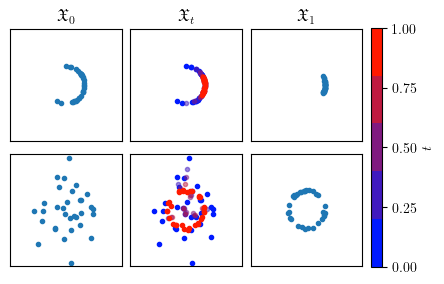

In [52]:
t = 0
N_steps = 240
Δt = 1. / N_steps
N_show = 5
N_skip = int(N_steps / (N_show-1))

N_models = len(tests)
N_samples = 32

g_0s_test = {}
g_1s_test = {}
g_ts_test = {}
for test in tests:
    generate_g_0, generate_g_1 = data_generator(test, ε=EPSILON)
    g_0s_test[test] = generate_g_0(N_samples).to(device)
    g_1s_test[test] = generate_g_1(N_samples).to(device)
    g_ts_test[test] = g_0s_test[test].detach().clone()
    
    models_FM[test].eval()

fig = plt.figure(figsize=(4.8, 2 * 1.6 * N_models * 3/3.1))
gs = gridspec.GridSpec(2 * N_models, 4, width_ratios=[1, 1, 1, 0.1], height_ratios=2 * N_models * [1.], wspace=0.1, hspace=0.1)
cax = fig.add_subplot(gs[:, 3])

ax = []
for i in range(2 * N_models):
    ax.append([])
    for j in range(3):
        a = fig.add_subplot(gs[i, j])
        a.set_xlim(-3, 3)
        a.set_ylim(-3, 3)
        a.set_xticks([])
        a.set_yticks([])
        a.set_aspect("equal")
        ax[i].append(a)
        
ax[0][0].set_title(r"$\mathfrak{X}_0$")
ax[0][1].set_title(r"$\mathfrak{X}_t$")
ax[0][2].set_title(r"$\mathfrak{X}_1$")
Δc = 1 / (N_show - 1)
colors = [(j * Δc, 0.1, 1 - j * Δc) for j in range(N_show)]
cmap = mcolors.ListedColormap(colors)
for i, test in enumerate(tests):
    k = 0

    ax[2*i][0].scatter(
        # g_0s_test[test][:N_samples, 0], g_0s_test[test][:N_samples, 1],
        torch.cos(g_0s_test[test][:N_samples, 0]), torch.sin(g_0s_test[test][:N_samples, 0]),
        # width=0.01, color="tab:blue"
        marker=".", color="tab:blue"
    )
    ax[2*i+1][0].scatter(
        g_0s_test[test][:N_samples, -2], g_0s_test[test][:N_samples, -1],
        marker="."
    )
    ax[2*i][2].scatter(
        # g_1s_test[test][:N_samples, 0], g_1s_test[test][:N_samples, 1],
        torch.cos(g_1s_test[test][:N_samples, 0]), torch.sin(g_1s_test[test][:N_samples, 0]),
        marker=".", color="tab:blue"
    )
    ax[2*i+1][2].scatter(
        g_1s_test[test][:N_samples, -2], g_1s_test[test][:N_samples, -1],
        marker="."
    )

    alpha = 1
    N_samples_shown = N_samples
    for j in range(N_steps+1):
        t = j * Δt
        if j == N_steps:
            alpha = 1
            N_samples_shown = N_samples
        with torch.no_grad():
            g_ts_test[test] = models_FM[test].step(g_ts_test[test], torch.Tensor([t]), torch.Tensor([Δt]))

        if j % N_skip == 0:
            g_ts_test_plot = g_ts_test[test].to("cpu")
            # ax[2*i][1].quiver(
            #     g_ts_test_plot[:N_samples_shown, 0], g_ts_test_plot[:N_samples_shown, 1],
            #     torch.cos(g_ts_test_plot[:N_samples_shown, 2]), torch.sin(g_ts_test_plot[:N_samples_shown, 2]),
            #     color=colors[k], width=0.01, alpha=alpha
            # )
            ax[2*i][1].scatter(
                # g_ts_test_plot[:N_samples_shown, 0], g_ts_test_plot[:N_samples_shown, 1],
                torch.cos(g_ts_test_plot[:N_samples_shown, 0]), torch.sin(g_ts_test_plot[:N_samples_shown, 0]),
                color=colors[k], marker=".", alpha=alpha
            )
            ax[2*i+1][1].scatter(
                g_ts_test_plot[:N_samples_shown, -2], g_ts_test_plot[:N_samples_shown, -1],
                color=colors[k], marker=".", alpha=alpha
            )
            k += 1
        alpha = 0.5
        N_samples_shown = N_samples // 4
fig.colorbar(ScalarMappable(cmap=cmap), cax=cax, ticks=np.linspace(0, 1, N_show), label="$t$");
fig.savefig(f"output/interpolation_SE2_by_R2.pdf", bbox_inches="tight")